# Prosperity is associated with instability in dynamical networks

Reproduction code of the following paper.

- Title: Prosperity is associated with instability in dynamical networks
- Authors: Cavaliere, Matteo, Sean Sedwards, Corina E. Tarnita, Martin A. Nowak, and Attila Csikász-Nagy
- Year: 2012
- Journal: Journal of theoretical biology 299 (2012): 126-138.
- DOI: https://doi.org/10.1016/j.jtbi.2011.09.005

# Environment

In [1]:
using JupyterFormatter
enable_autoformat()

using DataFrames
using Dates
using Graphs
using Plots
using Profile
using Random
using Statistics: mean
using Test: @test, @testset, @test_throws

print("Julia version: $(VERSION), Thread: $(Threads.nthreads())")

Julia version: 1.9.1, Thread: 10

# Model structure

In [2]:
mutable struct Model
    N::Int      # node count
    k::Int      # average network degree
    b::Float64  # benefit
    c::Float64  # cost
    δ::Float64  # selection strength
    μ::Float64  # mutation rate
    p::Float64  # probability that a child connects the parent
    q::Float64  # probability that a child connects the parent's neighbors
    steps::Int  # simulation steps
    agents::DataFrame
    graph::SimpleGraph{Int64}
    outputs::Matrix{Float16}

    function Model(;
        N::Int = 100,
        k::Int = 4,
        b::Float64 = 3.0,
        c::Float64 = 1.0,
        δ::Float64 = 0.01,
        μ::Float64 = 0.0001,
        p::Float64 = 0.6,
        q::Float64 = 0.85,
        steps::Int = 10_000,
    )
        agents = DataFrame(
            id = 1:N,
            is_cooperator = fill(true, N),
            payoff = fill(0.0, N),
            fitness = fill(0.0, N),
        )

        graph = random_regular_graph(N, k)

        # カラムが、(Cooperator Rate, Mean Degree, Largest Component Size, Prosperity) で、ステップ数分の行を持つ行列
        outputs = zeros(Float16, steps, 4)
        cooperator_rate_array = zeros(Float16, steps)
        mean_degree_array = zeros(Float16, steps)
        largest_component_size_array = zeros(Int16, steps)
        prosperity_array = zeros(Float16, steps)


        new(N, k, b, c, δ, μ, p, q, steps, agents, graph, outputs)
    end
end;

In [3]:
@testset "Model constructor" begin
    model = Model()
    @test nv(model.graph) == 100
    @test ne(model.graph) == 200
    @test degree(model.graph) == fill(4, model.N)
end;

Test Summary:     | Pass  Total  Time
Model constructor |    3      3  1.2s


# Model properties

In [4]:
@inline
function cooperator_rate(model::Model)::Float16
    mean(Float16.(model.agents.is_cooperator))
end

@inline
function mean_degree(model::Model)::Float16
    mean(Float16.(degree(model.graph)))
end

@inline
function prosperity(model::Model)::Float16
    """
    繁栄度 = 実際の合計ペイオフ ÷ 理論的に可能な最大合計ペイオフ
    """
    total_payoff = sum(model.agents.payoff)
    max_payoff = model.N * (model.N - 1) * (model.b - model.c)
    Float16(round(total_payoff / max_payoff, digits = 3))
end

@inline
function largest_component_size(model::Model)::Int16
    @inbounds group_size_list =
        [length(component) for component in connected_components(model.graph)]
    Int16(maximum(group_size_list))
end;

In [5]:
@testset "Model properties" begin
    model = Model()

    # 協力率
    ## 初期状態では全員協力者であることを確認
    @test cooperator_rate(model) == 1.0

    ## 1人だけ非協力者にすると協力率が99%に変化することを確認 (N = 100)
    model.agents[1, :is_cooperator] = false
    @test cooperator_rate(model) == Float16(0.99)

    # 平均次数
    ## 初期状態では平均次数は4.0であることを確認
    @test mean_degree(model) == 4.0

    # 繁栄度
    ## 初期状態では全てのエージェントのペイオフは0.0であるため、繁栄度は0.0であることを確認
    @test prosperity(model) == 0.0

    ## 1人が最大ペイオフを持つ場合、繁栄度が0.01になることを確認
    model.agents[1, :payoff] = (model.b - model.c) * (model.N - 1)
    @test prosperity(model) == Float16(0.01)

    ## 全員が最大ペイオフを持つ場合、繁栄度が1.0になることを確認
    model.agents.payoff = fill((model.b - model.c) * (model.N - 1), model.N)
    @test prosperity(model) == 1.0

    # 最大コンポーネントサイズ
    ## 初期状態では全エージェントが一つのネットワークで繋がっていることを確認
    @test largest_component_size(model) == model.N

    ## エージェント1をネットワークから切り離すと最大コンポーネントサイズが1減ることを確認
    for neighbor_id in deepcopy(neighbors(model.graph, 1))
        rem_edge!(model.graph, 1, neighbor_id)
    end
    @test largest_component_size(model) == model.N - 1
end;

Test Summary:    | Pass  Total  Time
Model properties |    8      8  0.0s


# Model functions

In [6]:
@inline
function reset_agents_payoff!(model::Model)::Nothing
    model.agents.payoff = fill(0.0, model.N)

    return
end

@inline
function calc_payoff!(model::Model)::Nothing
    # 協力者はコスト c を払う
    model.agents[model.agents.is_cooperator, :payoff] .-= model.c

    # 協力者に隣接する全てのエージェントは利益 b を得る
    @simd for cooperator_id in model.agents[model.agents.is_cooperator, :id]
        neighbor_ids = neighbors(model.graph, cooperator_id)
        model.agents[neighbor_ids, :payoff] .+= model.b
    end

    # 有効ペイオフ(適応度) fitness = (1+δ)^payoff
    model.agents.fitness = (1.0 + model.δ) .^ model.agents.payoff

    return
end

@inline
function kill_agent!(model::Model)::Int
    # 殺されるエージェントを選ぶ
    kill_agent_id = rand(model.agents.id)

    # 殺されるエージェントはネットワークから切り離される
    @simd for neighbor_id in deepcopy(neighbors(model.graph, kill_agent_id))
        rem_edge!(model.graph, kill_agent_id, neighbor_id)
    end

    # 殺されるエージェントの適応度を0にする
    model.agents[model.agents.id.==kill_agent_id, :fitness] .= 0.0

    return kill_agent_id
end

@inline
function choose_role_model(model::Model)::Int
    """
    新規参入者のロールモデルとなるノードは、母集団から確率的に選択される。
    ノード i がロールモデルとして選択される確率はその有効ペイオフ EPi に比例する。
    各ステップにおいて，ネットワークの有効ペイオフ総和は EPtot = ∑ i∈{1...N} として計算される。
    あるノードがロールモデルとして選ばれる確率はEPi / EPtotとなる。
    """
    total_fitness = sum(model.agents.fitness)
    role_model_index = total_fitness * rand()
    for agent in eachrow(model.agents)
        role_model_index -= agent.fitness
        role_model_index > 0 || return agent.id
    end

    throw(DomainError(role_model_index, "Something wrong..."))
end

@inline
function imitate_role_model!(model::Model, new_agent_id::Int, role_model_id::Int)::Nothing
    # 新規参入者は確率1-uでロールモデルの戦略をコピーするか，確率μで代替戦略に変異する。
    role_model_is_cooperator =
        model.agents[model.agents.id.==role_model_id, :is_cooperator][1]
    model.agents[model.agents.id.==new_agent_id, :is_cooperator] .=
        rand() > model.μ ? role_model_is_cooperator : !role_model_is_cooperator

    # 新規参入者は確率qでロールモデルの各近傍と接続する
    neighbor_ids = deepcopy(neighbors(model.graph, role_model_id))
    rand() < model.q && for neighbor_id in neighbor_ids
        add_edge!(model.graph, new_agent_id, neighbor_id)
    end

    # 確率pでロールモデルと直接接続する
    rand() < model.p && add_edge!(model.graph, new_agent_id, role_model_id)

    return
end

@inline
function output!(model::Model, step::Int)::Nothing
    model.outputs[step, :] = [
        cooperator_rate(model),
        mean_degree(model),
        largest_component_size(model),
        prosperity(model),
    ]
    return
end

function visualization(model::Model, post_fix::String)::Nothing
    plot(
        plot(
            model.outputs[:, 1],
            xlab = "Generation",
            ylab = "Cooperator Rate",
            legend = false,
        ),
        plot(
            model.outputs[:, 2],
            xlab = "Generation",
            ylab = "Mean Degree",
            legend = false,
        ),
        plot(model.outputs[:, 3], xlab = "Generation", ylab = "Prosperity", legend = false),
        plot(
            model.outputs[:, 4],
            xlab = "Generation",
            ylab = "Largest Component Size",
            legend = false,
        ),
        layout = (4, 1),
        size = (1200, 800),
    )

    savefig("img/plot_$(post_fix).png")

    return
end;

In [7]:
@testset "Model functions" begin
    Random.seed!()
    model = Model()

    @testset "reset_agents_payoff!" begin
        model.agents.payoff = fill(1.2, model.N)
        reset_agents_payoff!(model)
        @test model.agents.payoff == fill(0.0, model.N)
    end

    @testset "calc_payoff!" begin
        model.agents[1, :is_cooperator] = false
        calc_payoff!(model)
        @test model.agents[model.agents.id.==1, :payoff] >
              model.agents[model.agents.id.==2, :payoff]
        @test model.agents[model.agents.id.==1, :fitness] >
              model.agents[model.agents.id.==2, :fitness]
    end

    @testset "kill_agent!" begin
        kill_agent_id = kill_agent!(model)
        @test neighbors(model.graph, kill_agent_id) == []
    end

    @testset "choose_role_model" begin
        model.agents.fitness = fill(0.0, model.N)
        model.agents.fitness[43] = 1.0
        @test choose_role_model(model) == 43
    end

    @testset "imitate_role_model! (p = 1.0, q = 1.0)" begin
        model.μ = 0.0
        model.p = 1.0
        model.q = 1.0

        kill_agent_id = 1
        roll_model_id = 2

        model.agents[kill_agent_id, :is_cooperator] = true
        model.agents[roll_model_id, :is_cooperator] = false

        for neighbor_id in deepcopy(neighbors(model.graph, kill_agent_id))
            rem_edge!(model.graph, kill_agent_id, neighbor_id)
        end

        imitate_role_model!(model, kill_agent_id, roll_model_id)

        # 戦略の模倣
        @test model.agents[kill_agent_id, :is_cooperator] ==
              model.agents[roll_model_id, :is_cooperator] ==
              false

        # ネットワークの模倣
        @test filter(
            neighbor_ids -> neighbor_ids != roll_model_id,
            neighbors(model.graph, kill_agent_id),
        ) == filter(
            neighbor_ids -> neighbor_ids != kill_agent_id,
            neighbors(model.graph, roll_model_id),
        )

        # ロールモデルとの接続
        @test has_edge(model.graph, kill_agent_id, roll_model_id)
    end

    @testset "imitate_role_model! (p = 0.0, q = 0.0)" begin
        model.μ = 0.0
        model.p = 0.0
        model.q = 0.0

        kill_agent_id = 1
        roll_model_id = 2

        for neighbor_id in deepcopy(neighbors(model.graph, kill_agent_id))
            rem_edge!(model.graph, kill_agent_id, neighbor_id)
        end

        imitate_role_model!(model, kill_agent_id, roll_model_id)

        # q = 0.0の場合は、ロールモデルのネットワークを模倣しない
        @test neighbors(model.graph, kill_agent_id) == []

        # p = 0.0の場合は、ロールモデルと接続しない
        @test !has_edge(model.graph, kill_agent_id, roll_model_id)
    end
end;

Test Summary:   | Pass  Total  Time
Model functions |   10     10  0.7s


# Run all

In [8]:
function run_all!(; steps::Int)::Nothing
    Threads.@threads for trial = 1:Threads.nthreads()
        Random.seed!(MersenneTwister())
        model = Model(steps = steps)

        for step = 1:model.steps
            reset_agents_payoff!(model)
            calc_payoff!(model)
            new_agent_id = kill_agent!(model)
            role_model_id = choose_role_model(model)
            imitate_role_model!(model, new_agent_id, role_model_id)
            output!(model, step)

            step % 100_000 == 0 &&
                println("trial: $(trial), $(Time(now()))\t $(step / model.steps * 100)%")
        end

        visualization(model, "$(trial)")
    end

    return
end;

In [9]:
run_all!(steps = 5 * 10^6)

trial: 5, 16:43:25.584	 2.0%
trial: 6, 16:43:27.358	 2.0%
trial: 9, 16:43:35.438	 2.0%
trial: 10, 16:43:36.22	 2.0%
trial: 1, 16:43:36.62	 2.0%
trial: 4, 16:43:37.077	 2.0%
trial: 7, 16:43:37.082	 2.0%
trial: 2, 16:43:37.362	 2.0%
trial: 8, 16:43:37.378	 2.0%
trial: 3, 16:43:37.957	 2.0%
trial: 6, 16:43:40.397	 4.0%
trial: 10, 16:43:41.817	 4.0%
trial: 2, 16:43:46.364	 4.0%
trial: 2, 16:43:51.94	 6.0%
trial: 5, 16:43:52.966	 4.0%
trial: 9, 16:43:57.47	 4.0%
trial: 2, 16:43:57.57	 8.0%
trial: 5, 16:43:59.276	 6.0%
trial: 4, 16:44:01.591	 4.0%
trial: 9, 16:44:02.339	 6.0%
trial: 2, 16:44:03.119	 10.0%
trial: 1, 16:44:04.579	 4.0%
trial: 7, 16:44:04.715	 4.0%
trial: 8, 16:44:05.802	 4.0%
trial: 3, 16:44:06.679	 4.0%
trial: 9, 16:44:07.251	 8.0%
trial: 6, 16:44:07.861	 6.0%
trial: 10, 16:44:08.206	 6.0%
trial: 2, 16:44:10.449	 12.0%
trial: 9, 16:44:12.081	 10.0%
trial: 5, 16:44:16.382	 8.0%
trial: 6, 16:44:16.695	 8.0%
trial: 1, 16:44:18.014	 6.0%
trial: 4, 16:44:19.975	 6.0%
trial: 1, 16:

# Visualization

Trial 1


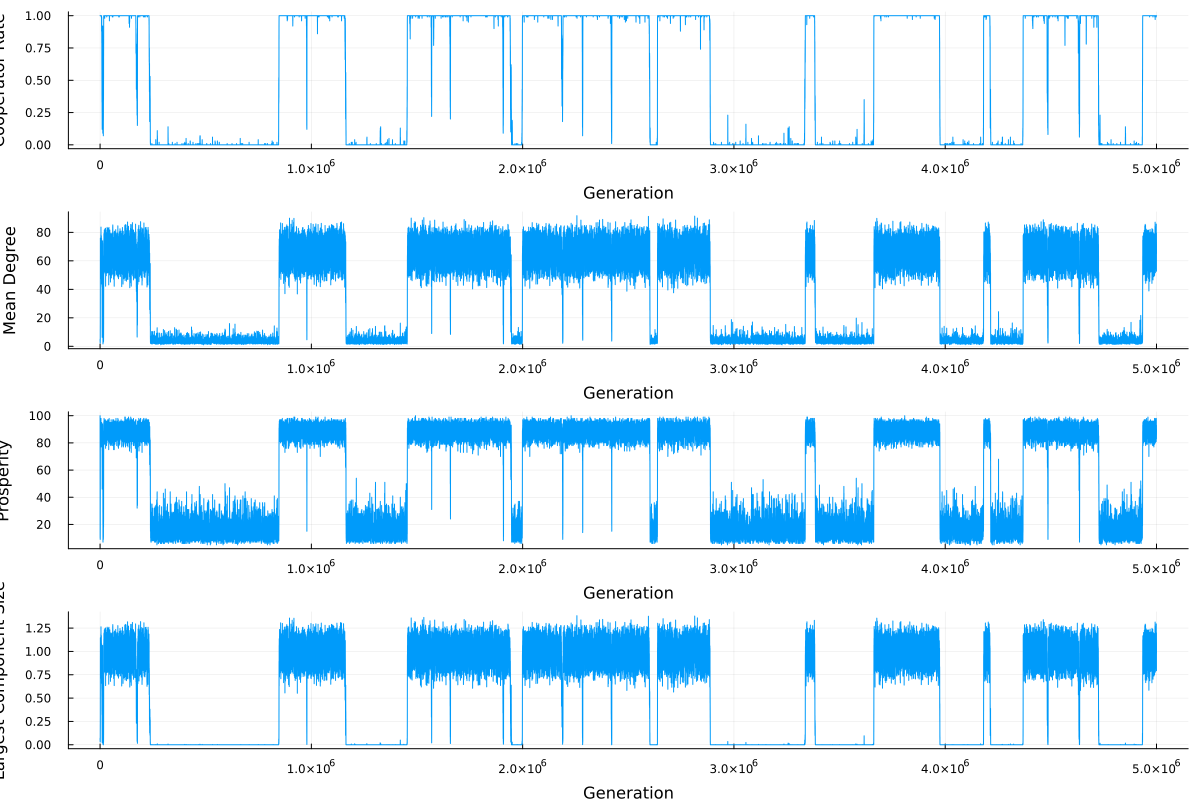

Trial 2


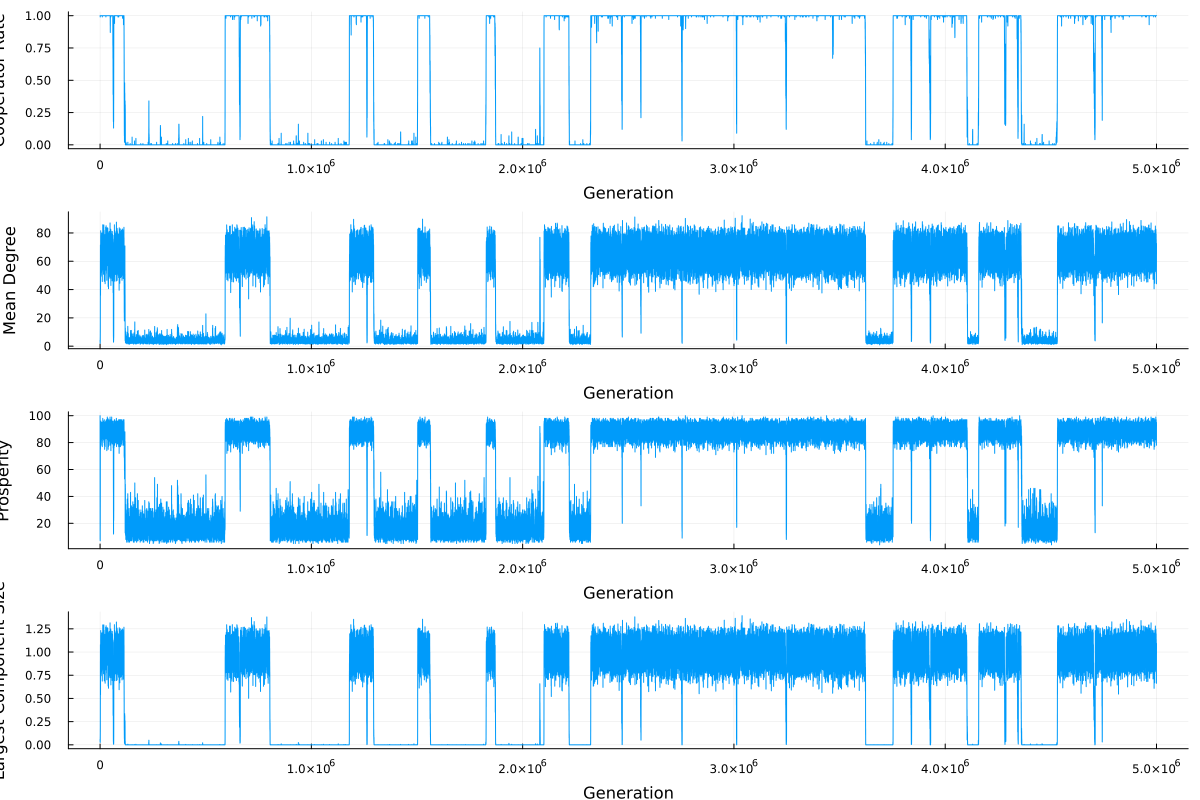

Trial 3


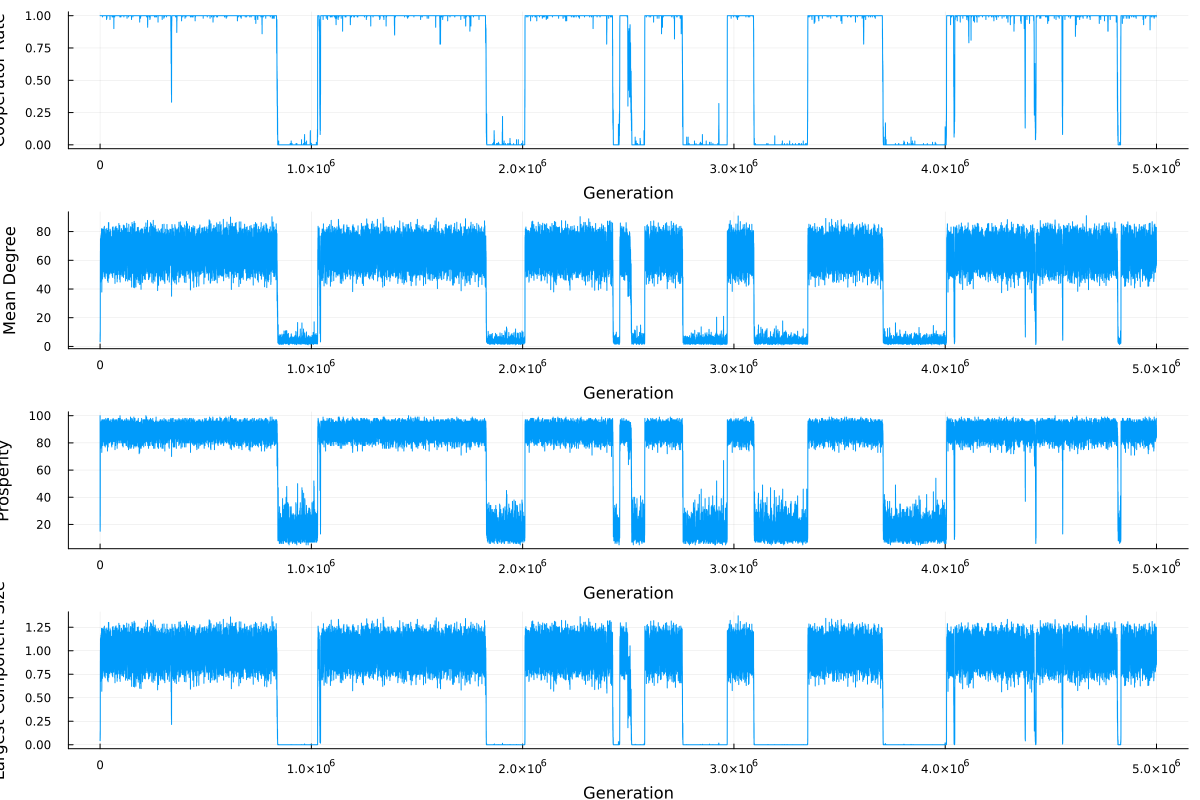

Trial 4


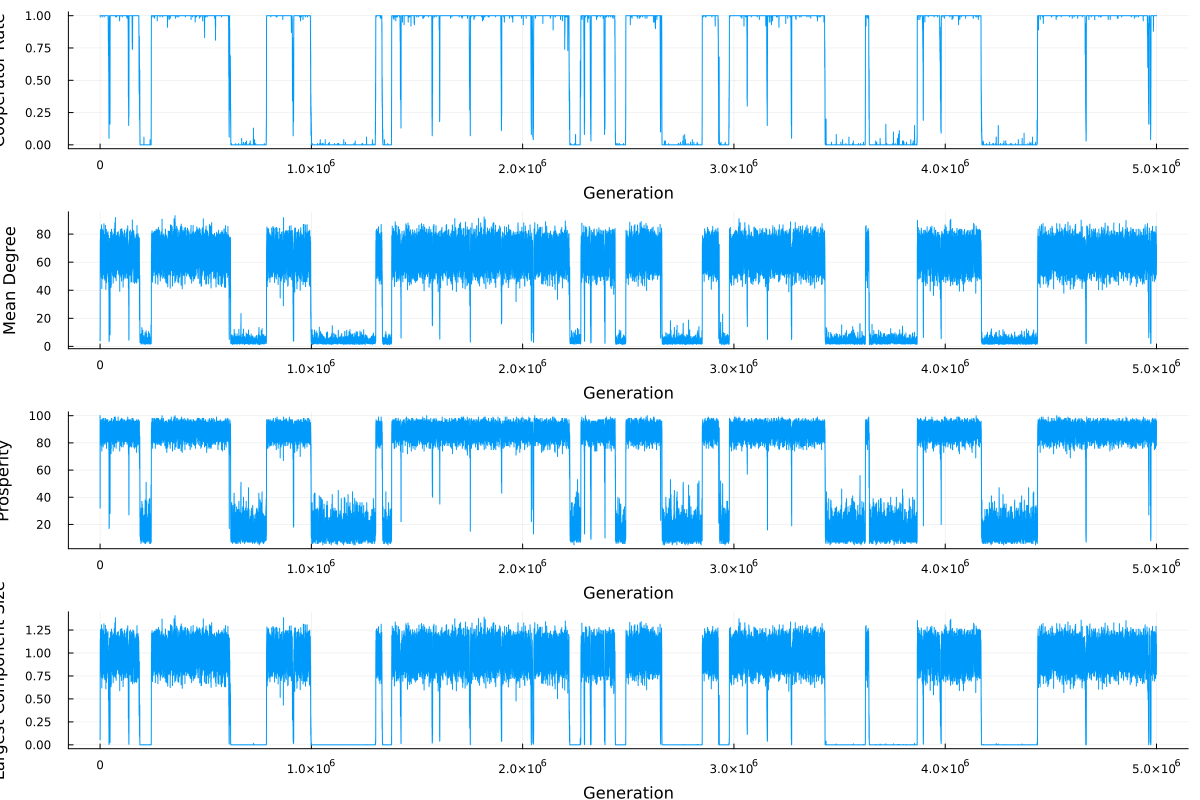

Trial 5


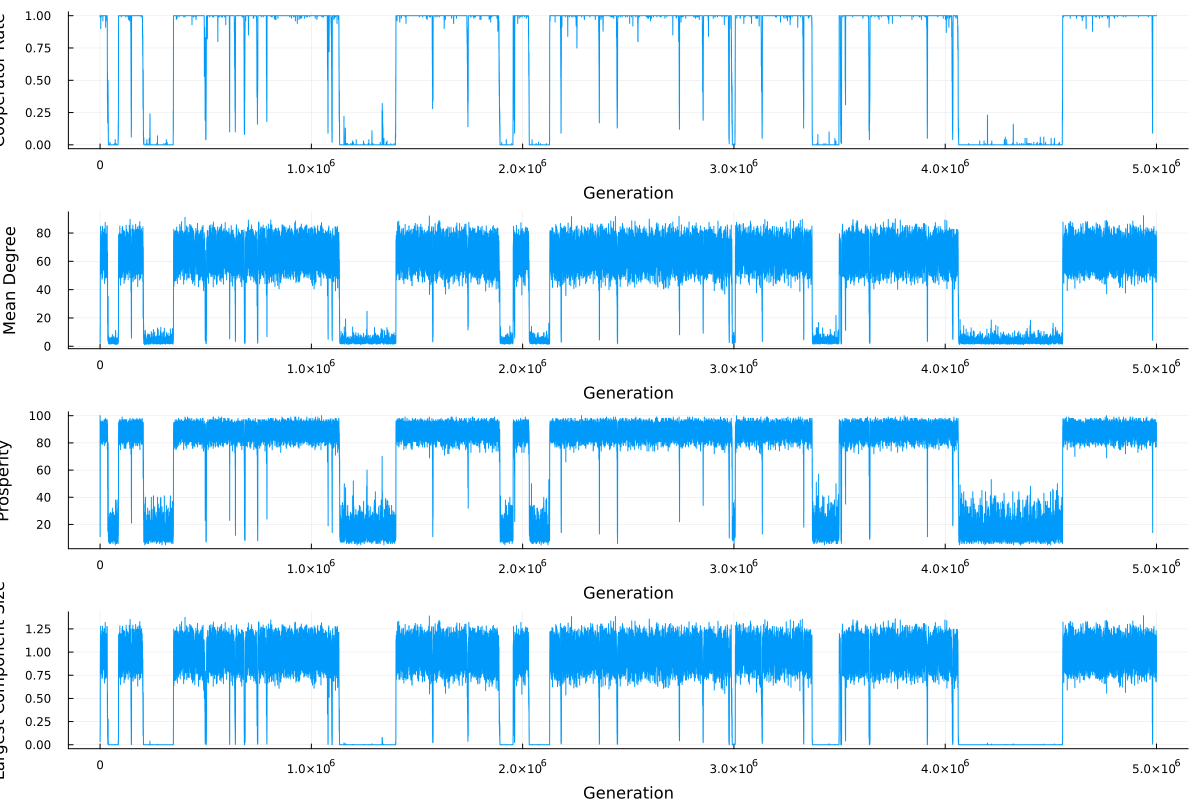

Trial 6


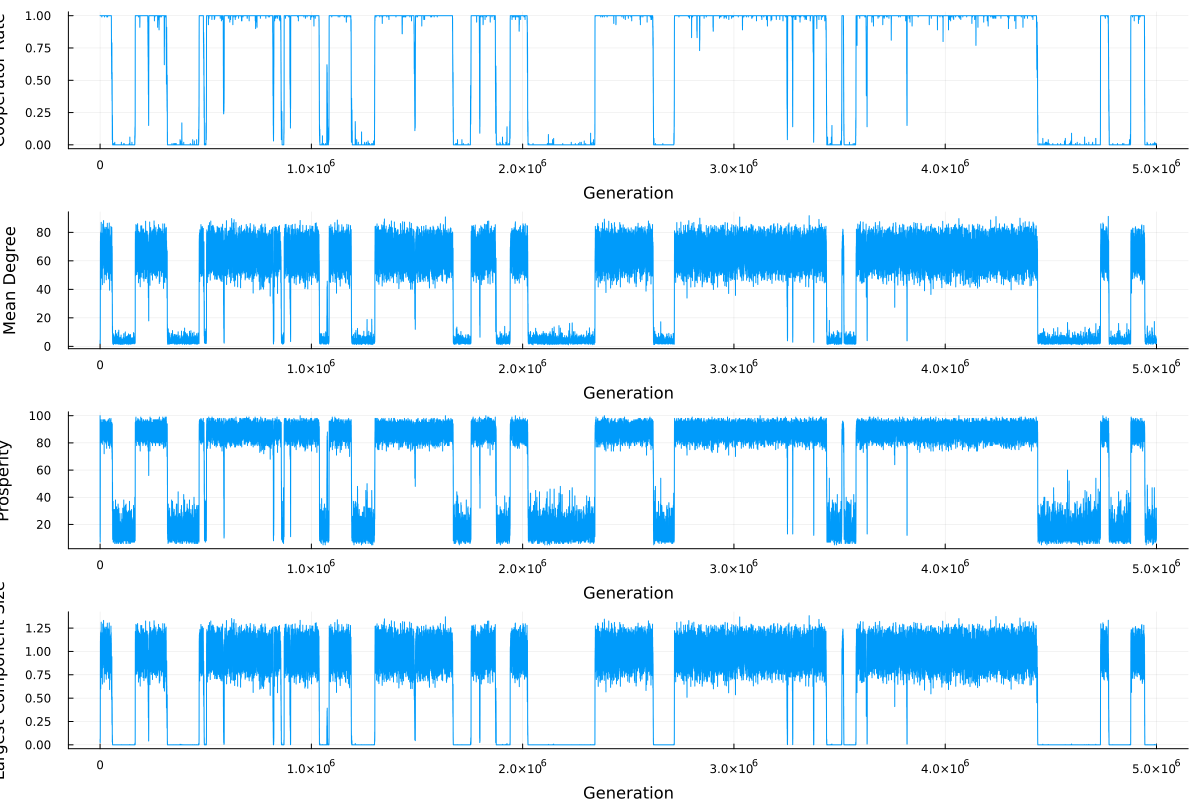

Trial 7


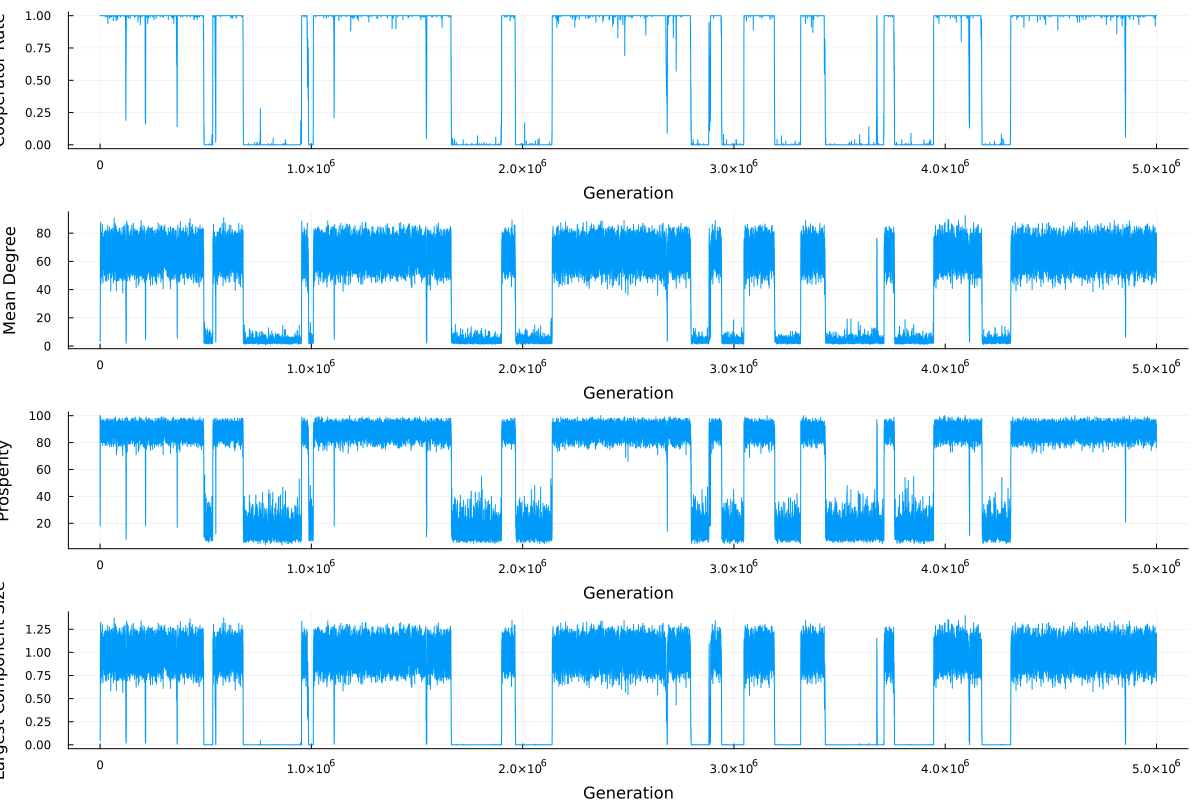

Trial 8


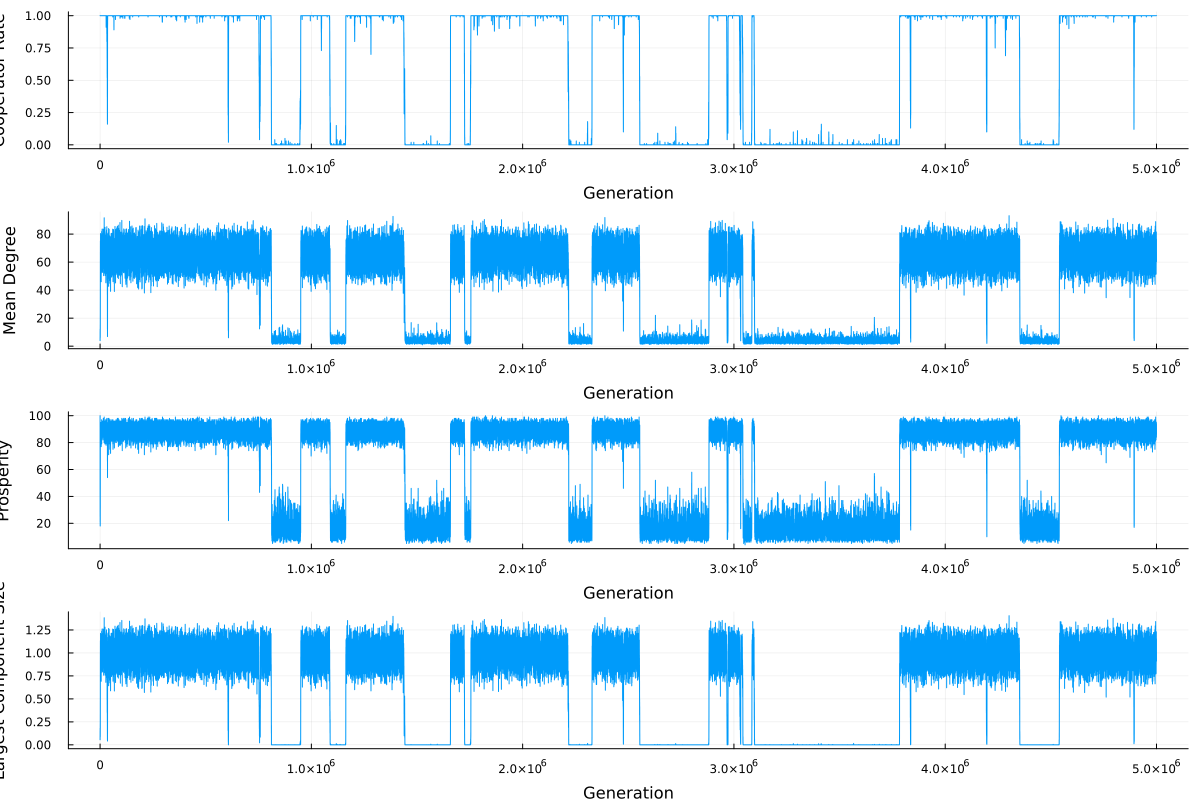

Trial 9


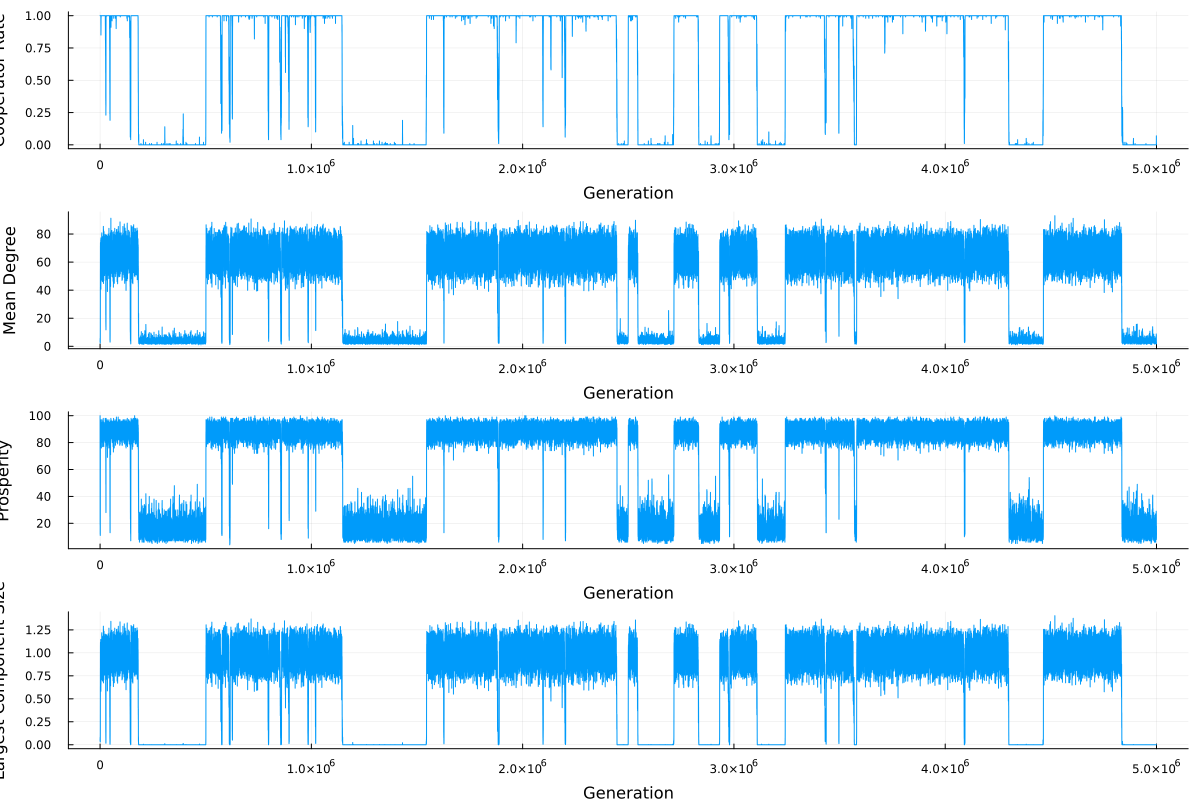

Trial 10


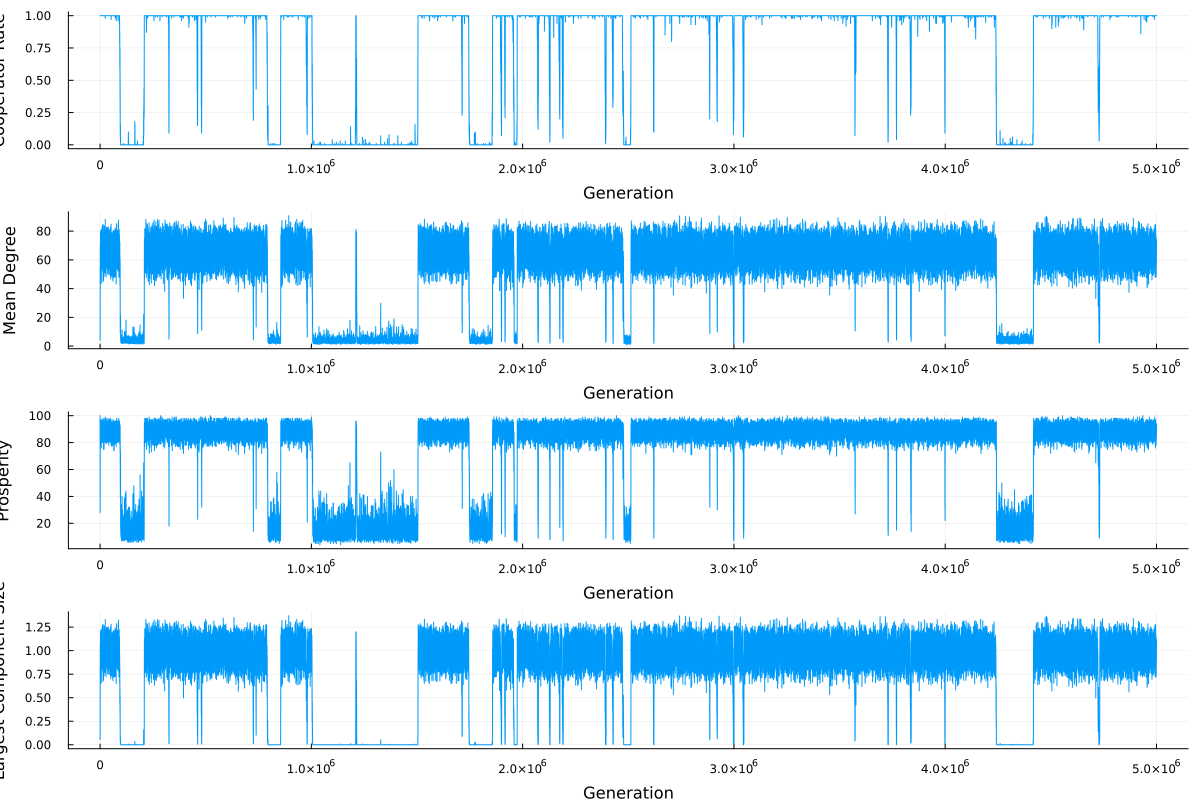

In [10]:
for trial = 1:Threads.nthreads()
    println("Trial $(trial)")
    display("image/png", read("img/plot_$(trial).png"))
end;

# Performance Profile

In [ ]:
Profile.clear()
model = Model()
run_all!(steps = 10^5)
@profile run_all!(steps = 10^5)
Profile.print()